In [11]:
from random import shuffle
from typing import List, Literal, Optional, Tuple
import math, heapq

UP = 'up'
DOWN = 'down'
LEFT = 'left'
RIGHT = 'right'

Move = Literal['up', 'down', 'left', 'right']
Solution = List[Move]
State = List[int]

def index_to_coords(index: int, dimension: int) -> tuple[int, int]:
    """ Convertit un index i d'une liste de taille dimension**2 en coordonnées (x, y) dans un tableau 2D de taille dimension x dimension."""
    i = index // dimension
    j = index % dimension
    return i, j

def coords_to_index(i: int, j: int, dimension: int) -> int:
    """ Convertit des coordonnées (i, j) en index dans une liste de taille dimension**2 """
    return i * dimension + j

def is_solvable(puzzle: State) -> bool:
    """ Check if the puzzle is solvable """
    dimension = int(math.sqrt(len(puzzle)))
    puzzle_without_blank = [element for element in puzzle if element != 0]
    inversion_count = 0
    for i in range(len(puzzle_without_blank) - 1):
        for j in range(i + 1, len(puzzle_without_blank)):
            if puzzle_without_blank[i] > puzzle_without_blank[j]:
                inversion_count += 1

    if dimension % 2 == 1:
        return inversion_count % 2 == 0
    else:
        blank_position = puzzle.index(0)

        blank_row = blank_position // dimension
        blank_row_from_bottom = dimension - blank_row
        return (inversion_count % 2 == 0) == (blank_row_from_bottom % 2 == 1)

def create_goal(dimension: int) -> State:
    """ Create the goal state of the puzzle """
    return [i for i in range(1, dimension ** 2)] + [0]
    
def is_goal(puzzle: State) -> bool:
    """Check if the puzzle is the goal state"""
    return create_goal(int(math.sqrt(len(puzzle)))) == puzzle   
     
def generate(dimension: int) -> State:
    """ Generate a random n-puzzle """
    init_state: State = [i for i in range(dimension ** 2)]
    while True:
        shuffle(init_state)
        if is_solvable(init_state):
            break
    return init_state

def move(puzzle: State, direction: Move) -> Optional[State]:
    """ Move the blank tile in the puzzle """
    dimension = int(math.sqrt(len(puzzle)))

    current_state = puzzle.copy()
    blank_index = current_state.index(0)
    i, j = index_to_coords(blank_index, dimension)
    target_index = None

    if direction == UP:
        if i - 1 < 0: 
            return None
        target_index = coords_to_index(i - 1, j, dimension)
    elif direction == DOWN:
        if i + 1 >= dimension: 
            return None
        target_index = coords_to_index(i + 1, j, dimension)
    elif direction == LEFT:
        if j - 1 < 0: 
            return None
        target_index = coords_to_index(i, j - 1, dimension)
    elif direction == RIGHT:
        if j + 1 >= dimension: 
            return None
        target_index = coords_to_index(i, j + 1, dimension)

    current_state[blank_index], current_state[target_index] = current_state[target_index], current_state[blank_index]
    return current_state

def get_neighbors(puzzle: State) -> List[Optional[State]]:
    """ Get the neighbors of the puzzle """
    state_list = []
    for direction in [UP, DOWN, LEFT, RIGHT]:
        new_state = move(puzzle, direction)
        state_list.append(new_state)
    return state_list

def solve_bfs(puzzle: State) -> Solution:
    if not is_solvable(puzzle):
        print("Non solvable !")
        return []

    visited = set()
    visited.add(tuple(puzzle))
    queue = [(puzzle, [])]

    while queue:
        current_state, path = queue.pop(0)
        if is_goal(current_state):
            return path

        for neighbor, direction in zip(get_neighbors(current_state), [UP, DOWN, LEFT, RIGHT]):
            if neighbor is None:
                continue
            state_tuple = tuple(neighbor)
            if state_tuple not in visited:
                visited.add(state_tuple)
                queue.append((neighbor, path + [direction]))
    return []

def solve_dfs(puzzle: State, max_depth=100) -> Solution:
    """Solve the puzzle using the DFS algorithm"""
    if not is_solvable(puzzle):
        print("Non solvable !")
        return []
    
    stack = [(puzzle, [], 0)]
    visited = set()
    visited.add(tuple(puzzle))
    
    while stack:
        current_state, path, depth = stack.pop()
        
        if is_goal(current_state):
            return path
        
        if depth >= max_depth:
            continue
            
        valid_moves = []
        neighbors = get_neighbors(current_state)
        directions = [UP, DOWN, LEFT, RIGHT]
        
        for neighbor, direction in zip(neighbors, directions):
            if neighbor is None:
                continue
            
            neighbor_tuple = tuple(neighbor)
            if neighbor_tuple not in visited:
                visited.add(neighbor_tuple)
                valid_moves.append((neighbor, path + [direction], depth + 1))
        
        for move in reversed(valid_moves):
            stack.append(move)
    
    return []
    
def heuristic(puzzle: State) -> int:
    """ Calculate Manhattan distance heuristic """
    total_distance = 0
    dimension = int(math.sqrt(len(puzzle)))
    
    for i in range(len(puzzle)):
        if puzzle[i] == 0:  # Skip the blank tile
            continue
            
        # Get current position
        current_x, current_y = index_to_coords(i, dimension)
        
        # Get target position for this value
        value = puzzle[i]
        target_pos = value - 1  # Adjust for 0-indexing
        target_x, target_y = index_to_coords(target_pos, dimension)
        
        # Add Manhattan distance
        total_distance += abs(current_x - target_x) + abs(current_y - target_y)
        
    return total_distance
    
def solve_astar(puzzle: State) -> Solution:
    """ Solve the puzzle using the A* algorithm """
    if not is_solvable(puzzle):
        print("Non solvable !")
        return []

    priority_queue = []
    initial_priority = heuristic(puzzle)
    heapq.heappush(priority_queue, (initial_priority, 0, puzzle, []))  # priority, move_count, state, path

    visited = set()
    visited.add(tuple(puzzle))
    
    while priority_queue:
        _, move_count, current_state, path = heapq.heappop(priority_queue)

        if is_goal(current_state):
            return path

        for state, direction in zip(get_neighbors(current_state), [UP, DOWN, LEFT, RIGHT]):
            if state is None: 
                continue
                
            state_tuple = tuple(state)
            if state_tuple not in visited:
                visited.add(state_tuple)
                new_path = path + [direction]
                new_move_count = move_count + 1
                priority = heuristic(state) + new_move_count
                heapq.heappush(priority_queue, (priority, new_move_count, state, new_path))
                
    return []

In [17]:
def generate_by_scrambling(dimension: int, scramble_moves: int) -> State:
    """
    Génère un puzzle à partir de l'état final en appliquant un certain nombre de mouvements valides.
    Le nombre de mouvements appliqués correspond à la difficulté.
    """
    state = create_goal(dimension)
    previous_move = None
    move_opposites = {UP: DOWN, DOWN: UP, LEFT: RIGHT, RIGHT: LEFT}
    
    for _ in range(scramble_moves):
        possible_moves = [m for m in [UP, DOWN, LEFT, RIGHT] if m != move_opposites.get(previous_move)]
        shuffle(possible_moves)
        for move_dir in possible_moves:
            new_state = move(state, move_dir)
            if new_state:
                state = new_state
                previous_move = move_dir
                break
    return state

""" Programme principal affichant le temps moyen d'execution pour chaque méthode en fonction de la difficulté (nombre de coups pour résoudre) du
puzzle, pour des raisons de temps d'executions seul les des taquin 3*3 sont générés. Le principe est de 

SyntaxError: incomplete input (1668061268.py, line 21)

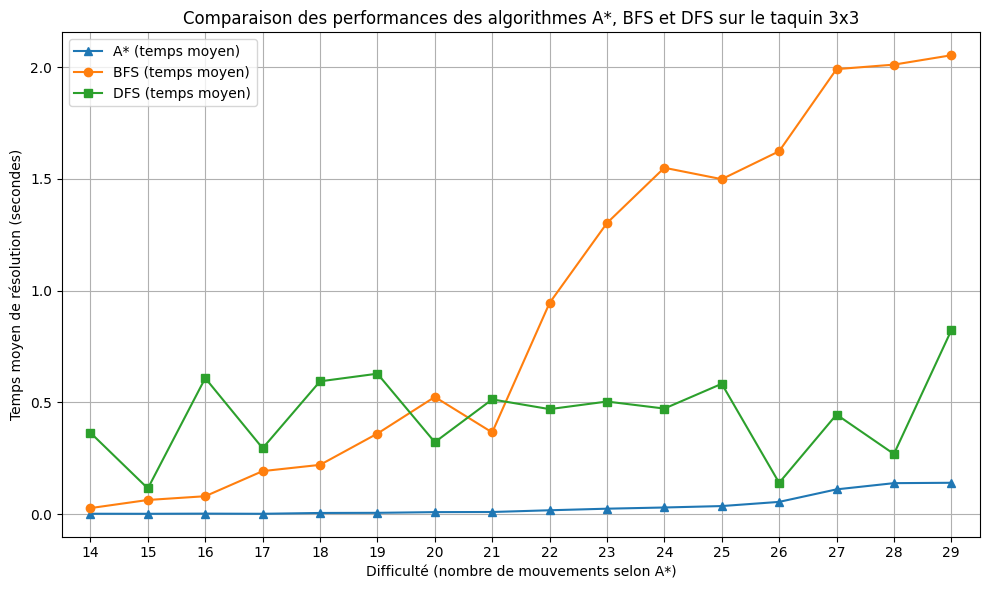

In [16]:
import matplotlib.pyplot as plt
import time

def measure_time(solver, puzzle):
    start = time.time()
    solution = solver(puzzle)
    end = time.time()
    elapsed = end - start
    return elapsed, len(solution)

def main():
    dimension = 3
    move_time_map_astar = {}
    move_time_map_bfs = {}
    move_time_map_dfs = {}
    
    for i in range(100):
        puzzle = generate(dimension)
        
        # A* - d'abord pour récupérer le nombre de mouvements comme référence
        time_astar, move_astar = measure_time(solve_astar, puzzle)
        move_time_map_astar.setdefault(move_astar, []).append(time_astar)

        # BFS et DFS utilisent move_astar comme clé, même s'ils trouvent une autre longueur
        time_bfs, _ = measure_time(solve_bfs, puzzle)
        move_time_map_bfs.setdefault(move_astar, []).append(time_bfs)

        time_dfs, _ = measure_time(solve_dfs, puzzle)
        move_time_map_dfs.setdefault(move_astar, []).append(time_dfs)
    
    # Trier les niveaux de difficulté (selon A*)
    all_moves = sorted(move_time_map_astar.keys())
    
    astar_times = []
    bfs_times = []
    dfs_times = []
    
    for move in all_moves:
        avg_time_astar = sum(move_time_map_astar[move]) / len(move_time_map_astar[move])
        avg_time_bfs   = sum(move_time_map_bfs[move])   / len(move_time_map_bfs[move])
        avg_time_dfs   = sum(move_time_map_dfs[move])   / len(move_time_map_dfs[move])
        
        astar_times.append(avg_time_astar)
        bfs_times.append(avg_time_bfs)
        dfs_times.append(avg_time_dfs)
    
    # Tracé
    plt.figure(figsize=(10, 6))
    
    if all_moves:
        min_label = min(all_moves)
        max_label = max(all_moves)
        step = max(1, (max_label - min_label) // 10)
        x_ticks = list(range(min_label, max_label + 1, step))

        plt.plot(all_moves, astar_times, label='A* (temps moyen)', marker='^')
        plt.plot(all_moves, bfs_times, label='BFS (temps moyen)', marker='o')
        plt.plot(all_moves, dfs_times, label='DFS (temps moyen)', marker='s')
        plt.xticks(x_ticks)
        plt.xlim(min_label - 0.5, max_label + 0.5)
    else:
        print("Aucune donnée à afficher.")
    
    plt.xlabel("Difficulté (nombre de mouvements selon A*)")
    plt.ylabel("Temps moyen de résolution (secondes)")
    plt.title("Comparaison des performances des algorithmes A*, BFS et DFS sur le taquin 3x3")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

main()
